<center><h1>Mapping Defect Rates by State and Zip Code</h1></center>

<center>Using Python and R</center>

In [2]:
# load the rpy2 extension to allow us to send data to the R environment
%load_ext rpy2.ipython

In [5]:
%matplotlib inline
from IPython.html import widgets
from IPython.display import display
import pyodbc                # Needed to connect to ODBC data sources
import crypto, codecs
import numpy as np
import pandas as pd
pd.set_option("display.max_rows",1000)

# Get the necessary input from the user
year      = input("Enter model year(s) separated by comma: ")
factory   = input("Enter factory code(s) separated by comma: ").upper()
model     = input("Enter model name(s) separated by comma: ").upper()
dest_code = input("Enter destination code(s) separated by comma: ").upper()
part      = input("Enter part number(s) separated by comma: ")

:0: FutureWarning: IPython widgets are experimental and may change in the future.


Enter model year(s) separated by comma: 2011,2012
Enter factory code(s) separated by comma: hmin
Enter model name(s) separated by comma: civic
Enter destination code(s) separated by comma: ka,kl
Enter part number(s) separated by comma: 79160


### Enter contention criteria below or leave blank

In [6]:
ta = widgets.Textarea(
    description='Contention Criteria:',
    value='',
)
display(ta)
#  RO.ORIG_CMPLN_DESC LIKE '%%NOIS%%'
#  RO.ORIG_CAUS_DESC LIKE '%%NOIS%%'
#  RO.ORIG_CRRT_DESC LIKE '%%NOIS%%'

### Execute all cells below:

In [7]:
key = codecs.escape_decode(open(r'D:\webapps\_server\pyodbc\key', 'r').read())[0]
pw_file = open(r'D:\webapps\_server\pyodbc\cmq.txt', 'r')
pwd = pw_file.read()
pw = crypto.decrypt_with_key(key, pwd)
userid = 'rb10'
pw_file.close()

cnxn_string = 'DSN=CMQ_PROD;UID=' + userid + ';PWD=' + pw

cnxn = pyodbc.connect(cnxn_string)
cursor = cnxn.cursor()

from datetime import datetime
start = datetime.now()

# Make a list for each parameter input
years      = year.split(',')
factories  = factory.split(',')
models     = model.split(',')
dest_codes = dest_code.split(',')
parts      = part.split(',')

# Now get the number of items in each list so that we can properly use the .join() function below
Y = len(years)       # The number of years the user entered
F = len(factories)   # The number of factories the user entered
M = len(models)      # The number of models the user entered
D = len(dest_codes)  # The number of destination codes the user entered
P = len(parts)       # The number of part numbers the user entered

sql1 = """
WITH VEHICLES as (
SELECT
PROD.VIN_SK,
RTL_DLR.STATE_CD,
LEFT(RTL_DLR.POSTAL_CD,5) AS POSTAL_CD

FROM CMQ.V_FACT_VHCL_PRDN_SLS prod

INNER JOIN CMQ.V_DIM_MTO MTO
ON PROD.MTO_SK = MTO.MTO_SK

INNER JOIN CMQ.V_DIM_DLR RTL_DLR
ON PROD.RTL_DLR_SK = RTL_DLR.DLR_SK

WHERE
MTO.MDL_YR IN(%s)
AND MTO.FCTRY_CD IN(%s)
AND MTO.MDL_NM IN(%s)
AND MTO.DEST_CD IN(%s)
),

CLAIMS AS (
SELECT
CLAIMS.CLM_SK,
CLAIMS.VIN_SK,
CLM_DLR.STATE_CD,
LEFT(CLM_DLR.POSTAL_CD,5) AS POSTAL_CD

FROM CMQ.V_FACT_CLM_TRX CLAIMS

INNER JOIN CMQ.V_DIM_CLM CLAIM_DETAILS
ON CLAIMS.CLM_SK = CLAIM_DETAILS.CLM_SK

INNER JOIN CMQ.V_DIM_MTO MTO
ON CLAIMS.MTO_SK = MTO.MTO_SK

INNER JOIN CMQ.V_DIM_PART FAIL_PART
ON CLAIMS.FAIL_PART_SK = FAIL_PART.PART_SK

INNER JOIN CMQ.V_DIM_SUBL_CD SUBLET1
ON CLAIMS.SUBL_01_SK = SUBLET1.SUBL_CD_SK

INNER JOIN CMQ.V_DIM_SUBL_CD SUBLET2
ON CLAIMS.SUBL_02_SK = SUBLET2.SUBL_CD_SK

INNER JOIN CMQ.V_DIM_DLR CLM_DLR
ON CLAIMS.SVC_DLR_SK = CLM_DLR.DLR_SK

INNER JOIN CMQ.V_DIM_RO RO
ON CLAIMS.RO_SK = RO.RO_SK

WHERE
MTO.MDL_YR IN(%s)
AND MTO.FCTRY_CD IN(%s)
AND MTO.MDL_NM IN(%s)
AND MTO.DEST_CD IN(%s)
AND CLAIMS.CAMP_SK <= 0
AND NOT LEFT(CLAIM_DETAILS.CLM_NO,1) IN ('T', 'R')
AND NOT LEFT(FAIL_PART.PART_NO,2) = '08'
AND NOT FAIL_PART.SHRT_PART_NO IN ('TCHV','TCAV')
AND NOT SUBLET1.SUBL_CD = 'GW'
AND NOT SUBLET2.SUBL_CD = 'GW'
"""

sql2 = ta.value

sql3 = """
),

REPLACED as (
SELECT
REPLPART.CLM_SK

FROM CMQ.V_FACT_CLM_REPL_PART REPLPART

INNER JOIN CLAIMS CLAIMS
ON REPLPART.CLM_SK = CLAIMS.CLM_SK

INNER JOIN CMQ.V_DIM_PART PART
ON PART.PART_SK = REPLPART.REPL_PART_SK

WHERE
PART.SHRT_PART_NO IN(%s)
AND REPLPART.REPL_PART_QTY > 0
AND REPLPART.ADJ_PART_QTY > 0
AND REPLPART.VHCL_DEST_CD IN(%s)
),

claims_unique as (
SELECT
MIN(REPLACED.CLM_SK) as CLM_SK,
CLAIMS.VIN_SK,
CLAIMS.STATE_CD,
CLAIMS.POSTAL_CD

FROM claims claims

INNER JOIN REPLACED REPLACED ON
CLAIMS.CLM_SK = REPLACED.CLM_SK

GROUP BY
CLAIMS.VIN_SK,
CLAIMS.STATE_CD,
CLAIMS.POSTAL_CD
)

SELECT
MDL_YR,
FCTRY_CD,
MDL_NM,
AF_MTH,
RO_MTH,
STATE_CD,
POSTAL_CD,
SUM(SALE_QTY) AS SALE_QTY,
SUM(VEH_QTY) AS VEH_QTY,
SUM(CLAIM_QTY) AS CLAIM_QTY,
SUM(CLAIM_AMT) AS CLAIM_AMT

FROM (
    SELECT
    MDL_YR,
    FCTRY_CD,
    MDL_NM,
    AF_MTH,
    RO_MTH,
    STATE_CD,
    POSTAL_CD,
    SUM(SALE_QTY) AS SALE_QTY,
    SUM(VEH_QTY) AS VEH_QTY,
    SUM(CLAIM_QTY) AS CLAIM_QTY,
    SUM(CLAIM_AMT) AS CLAIM_AMT

    FROM (
        SELECT
        MTO.MDL_YR AS MDL_YR,
        MTO.FCTRY_CD AS FCTRY_CD,
        MTO.MDL_NM AS MDL_NM,
        AF_CAL.CAL_YR_MO_FMT_NO AS AF_MTH,
        SALE_CAL.CAL_YR_MO_FMT_NO AS RO_MTH,
        VEHICLES.STATE_CD,
        VEHICLES.POSTAL_CD,

        CASE
        WHEN PROD.RTL_SLS_DT_SK > 0
        THEN 1
        ELSE 0
        END AS SALE_QTY,

        1 AS VEH_QTY,
        0 AS CLAIM_QTY,
        0 AS CLAIM_AMT

        FROM VEHICLES VEHICLES

        INNER JOIN CMQ.V_FACT_VHCL_PRDN_SLS PROD
        ON VEHICLES.VIN_SK = PROD.VIN_SK

        INNER JOIN CMQ.V_DIM_MTO MTO
        ON PROD.MTO_SK = MTO.MTO_SK
        
        INNER JOIN CMQ.V_DIM_DATE AF_CAL
        ON PROD.AF_OFF_DT_SK = AF_CAL.CAL_DT_SK

        INNER JOIN CMQ.V_DIM_DATE SALE_CAL
        ON PROD.RTL_SLS_DT_SK = SALE_CAL.CAL_DT_SK

        WHERE
        VEHICLES.VIN_SK IS NOT NULL

    ) AS VEH

    GROUP BY
    MDL_YR,
    FCTRY_CD,
    MDL_NM,
    AF_MTH,
    RO_MTH,
    STATE_CD,
    POSTAL_CD

    UNION

    SELECT
    MDL_YR,
    FCTRY_CD,
    MDL_NM,
    AF_MTH,
    RO_MTH,
    STATE_CD,
    POSTAL_CD,
    SUM(SALE_QTY) AS SALE_QTY,
    SUM(VEH_QTY) AS VEH_QTY,
    SUM(CLAIM_QTY) AS CLAIM_QTY,
    SUM(CLAIM_AMT) AS CLAIM_AMT

    FROM (
        SELECT
        MTO.MDL_YR AS MDL_YR,
        MTO.FCTRY_CD AS FCTRY_CD,
        MTO.MDL_NM AS MDL_NM,
        AF_CAL.CAL_YR_MO_FMT_NO AS AF_MTH,
        RO_CAL.CAL_YR_MO_FMT_NO AS RO_MTH,
        CLAIMS_UNIQUE.STATE_CD,
        CLAIMS_UNIQUE.POSTAL_CD,

        0 AS SALE_QTY,

        0 AS VEH_QTY,
        1 AS CLAIM_QTY,
        FCLAIMS.USD_REMB_CLM_AMT AS CLAIM_AMT

        FROM CLAIMS_UNIQUE CLAIMS_UNIQUE

        INNER JOIN REPLACED
        ON CLAIMS_UNIQUE.CLM_SK = REPLACED.CLM_SK

        INNER JOIN CMQ.V_FACT_VHCL_PRDN_SLS PROD
        ON CLAIMS_UNIQUE.VIN_SK = PROD.VIN_SK

        INNER JOIN CMQ.V_FACT_CLM_TRX FCLAIMS
        ON CLAIMS_UNIQUE.CLM_SK = FCLAIMS.CLM_SK

        INNER JOIN CMQ.V_DIM_MTO MTO
        ON PROD.MTO_SK = MTO.MTO_SK
        
        INNER JOIN CMQ.V_DIM_DATE AF_CAL
        ON PROD.AF_OFF_DT_SK = AF_CAL.CAL_DT_SK

        INNER JOIN CMQ.V_DIM_DATE RO_CAL
        ON FCLAIMS.RO_DT_SK = RO_CAL.CAL_DT_SK

        WHERE
        CLAIMS_UNIQUE.CLM_SK IS NOT NULL

    ) AS CLM

    GROUP BY
    MDL_YR,
    FCTRY_CD,
    MDL_NM,
    AF_MTH,
    RO_MTH,
    STATE_CD,
    POSTAL_CD

) AS FINAL

GROUP BY
MDL_YR,
FCTRY_CD,
MDL_NM,
AF_MTH,
RO_MTH,
STATE_CD,
POSTAL_CD
"""

sql = sql1 + sql2 + sql3
sql = sql % (",".join("?" * Y), ",".join("?" * F), ",".join("?" * M), ",".join("?" * D), 
       ",".join("?" * Y), ",".join("?" * F), ",".join("?" * M), ",".join("?" * D), 
       ",".join("?" * P), ",".join("?" * D))

parameter_list = []
for year in years:
    parameter_list.append(year)
    
for factory in factories:
    parameter_list.append(factory)

for model in models:
    parameter_list.append(model)
    
for code in dest_codes:
    parameter_list.append(code)
    
for year in years:
    parameter_list.append(year)
    
for factory in factories:
    parameter_list.append(factory)

for model in models:
    parameter_list.append(model)
    
for code in dest_codes:
    parameter_list.append(code)
    
for p in parts:
    parameter_list.append(p)
    
for code in dest_codes:
    parameter_list.append(code)

df = pd.read_sql(sql, cnxn, index_col=None, params=parameter_list)

# Close connections
cursor.close()
cnxn.close()

# Exclude unsold units
df = df[df['RO_MTH']!='9999-12']

df['LABEL'] = df['MDL_YR'].map(str) + '-' + df['MDL_NM'].map(str) + '-' +df['FCTRY_CD'].map(str)

############################  State level Routine  ############################
state_sales = pd.pivot_table(df,values='SALE_QTY',index='STATE_CD',columns=['LABEL'],aggfunc=np.sum)

# Get column names
categories = state_sales.columns

# Rename columns
state_sales.columns = [column + ' Sales' for column in state_sales.columns]

# Get claims
state_claims = pd.pivot_table(df,values='CLAIM_QTY',index='STATE_CD',columns=['LABEL'],aggfunc=np.sum)

# Rename columns
state_claims.columns = [column + ' Claims' for column in state_claims.columns]

# Left join the 2 data sets
state_left_joined = pd.merge(state_sales,state_claims,how='left',left_index=True,right_index=True)

# Dynamically create defect rate columns and column names
i = 0
header_size = len(categories)
while i < header_size:
    for label in categories:
        state_left_joined[label + ' Defect Rate'] = state_left_joined.iloc[:,i+header_size] / state_left_joined.iloc[:,i] * 100
        i = i + 1

# create a dataframe with columns containing the word 'Defect'
state_defect_rates = state_left_joined.filter(like='Defect')

# Convert index to column
state_defect_rates.reset_index(level=0, inplace=True)

# code to name mapping
state_cd_to_state_name = {
'AL': 'alabama',
'AK': 'alaska',
'AR': 'arkansas',
'AZ': 'arizona',
'CA': 'california',
'CO': 'colorado',
'CT': 'connecticut',
'DE': 'delaware',
'FL': 'florida',
'GA': 'georgia',
'HI': 'hawaii',
'IA': 'iowa',
'ID': 'idaho',
'IL': 'illinois',
'IN': 'indiana',
'KS': 'kansas',
'KY': 'kentucky',
'LA': 'louisiana',
'ME': 'maine',
'MA': 'massachusetts',
'MD': 'maryland',
'MI': 'michigan',
'MN': 'minnesota',
'MO': 'missouri',
'MS': 'mississippi',
'MT': 'montana',
'NC': 'north carolina',
'ND': 'north dakota',
'NE': 'nebraska',
'NH': 'new hampshire',
'NJ': 'new jersey',
'NM': 'new mexico',
'NV': 'nevada',
'NY': 'new york',
'OH': 'ohio',
'OK': 'oklahoma',
'OR': 'oregon',
'PA': 'pennsylvania',
'RI': 'rhode island',
'SC': 'south carolina',
'SD': 'south dakota',
'TN': 'tennessee',
'TX': 'texas',
'UT': 'utah',
'VA': 'virginia',
'VT': 'vermont',
'WA': 'washington',
'WI': 'wisconsin',
'WV': 'west virginia',
'WY': 'wyoming'
}

# Implement the mapping
state_defect_rates['STATE_NAME'] = state_defect_rates['STATE_CD'].map(state_cd_to_state_name)

# Get master list of state names and state codes
state_name_df = pd.read_csv(r'D:\temp\state_defect_rates.csv', dtype={'DEFECT_RATE':np.float64})

# Left join
states_data = pd.merge(state_name_df,state_defect_rates,how='left', on='STATE_NAME')
states_data.fillna(value=0.00, inplace=True)

# Remove duplicate state code column that can have empty values
states_data.drop('STATE_CD',axis=1,inplace=True)

states_data.drop('STATE_CODE',axis=1,inplace=True)


#############################  Zip Code Section  #############################
zip_sales = pd.pivot_table(df,values='SALE_QTY',index='POSTAL_CD',columns=['LABEL'],aggfunc=np.sum)
zip_sales.columns = [column + ' Sales' for column in zip_sales.columns]

zip_claims = pd.pivot_table(df,values='CLAIM_QTY',index='POSTAL_CD',columns=['LABEL'],aggfunc=np.sum)
zip_claims.columns = [column + ' Claims' for column in zip_claims.columns]

# Left join the 2 data sets
zip_left_joined = pd.merge(zip_sales,zip_claims,how='left',left_index=True,right_index=True)

# Dynamically create defect rate columns and column names
i = 0
header_size = len(categories)
while i < header_size:
    for label in categories:
        zip_left_joined[label + ' Defect Rate'] = zip_left_joined.iloc[:,i+header_size] / zip_left_joined.iloc[:,i] * 100
        i = i + 1

# create a dataframe with columns containing the word 'Defect'
zip_defect_rates = zip_left_joined.filter(like='Defect')

# Convert index to column
zip_defect_rates.reset_index(level=0, inplace=True)
zip_defect_rates.replace([np.inf, -np.inf], np.NaN, inplace=True)
zip_defect_rates.fillna(value=0.00, inplace=True)

In [8]:
%R -i states_data

In [9]:
%%R -w 1000 -h 600 -u px # Set dimension of R's output.  Instead of px, you can also choose 'in', 'cm', or 'mm'
df <- as.data.frame(states_data)
library(choroplethr)

state_choropleths = list()
for (i in 2:ncol(states_data)) {
  df           = states_data[, c(1, i)]
  colnames(df) = c("region", "value")
  title        = paste0("Air Mix Motor Failures: ", colnames(states_data)[i])
  state_choropleths[[i-1]] = state_choropleth(df, title=title, legend="Defect Rate (%)", buckets=7)
}

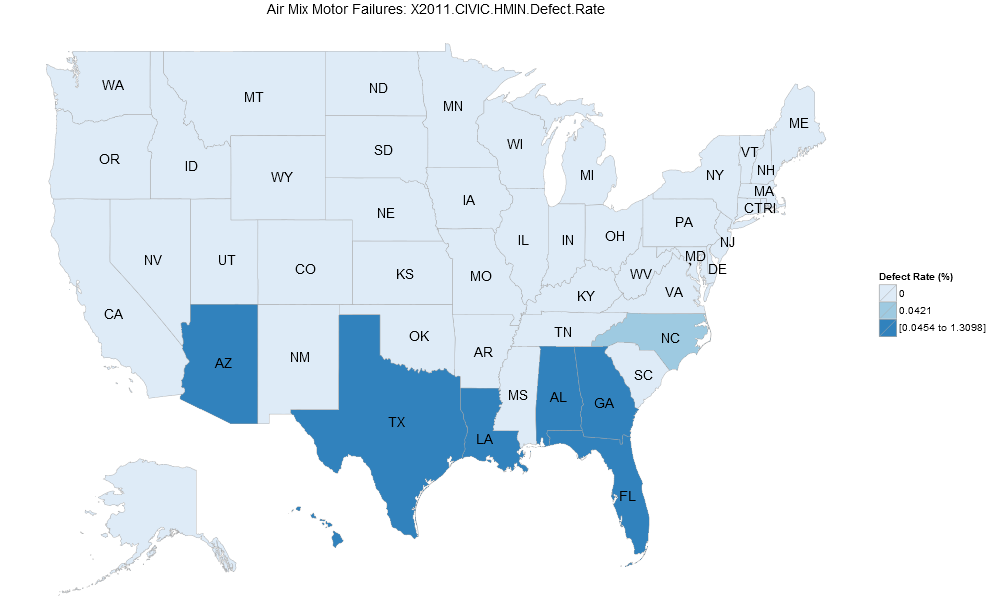

In [10]:
%%R -w 1000 -h 600 -u px
state_choropleths[1]

In [11]:
%R -i zip_defect_rates

In [12]:
%%R -w 1000 -h 600 -u px # Set dimension of R's output.  Instead of px, you can also choose 'in', 'cm', or 'mm'
df <- as.data.frame(zip_defect_rates)
library(choroplethr)

zip_choropleths = list()
for (i in 2:ncol(zip_defect_rates)) {
  df           = zip_defect_rates[, c(1, i)]
  colnames(df) = c("region", "value")
  title        = paste0("Air Mix Motor Failures: ", colnames(zip_defect_rates)[i])
  zip_choropleths[[i-1]] = zip_map(df, title="2011 Civic Air Mix Motor Failures by Zip Code", legend="Defect Rate (%)", buckets=7)
}

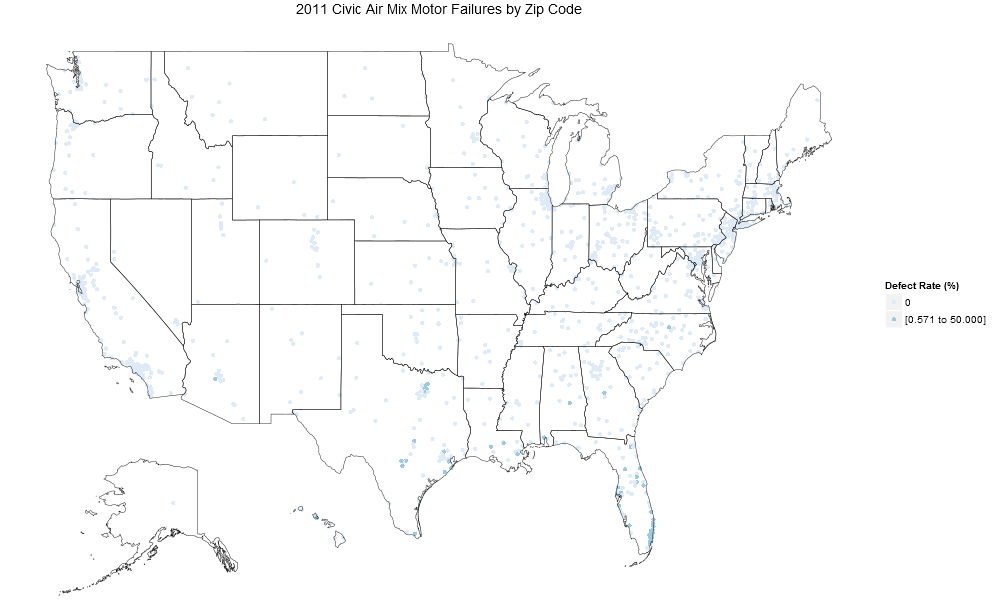

In [13]:
%%R -w 1000 -h 600 -u px
zip_choropleths[1]